### Install & Prepare

In [1]:
# Align with Colab's stack (NumPy 2.x, Python 3.12) and install what we actually need
!pip install -q -U pip setuptools wheel

# Key packages:
!pip install jedi==0.16
!pip install -q -U numpy==2.0.2 tensorflow==2.19.0  matplotlib

In [2]:
# Importing essential deep learning libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
print("TF:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))
print("Numpy:", np.__version__)
import matplotlib
print("Matplotlib:", matplotlib.__version__)

TF: 2.19.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Numpy: 2.0.2
Matplotlib: 3.10.7


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
PROJECT_ROOT = "/content/drive/MyDrive/Colab Notebooks/Electric_Motor_Fault_Diagnosis_based_on_Thermal_Images/data"

### Setting up the model with ResNet50

In [5]:
# Defining dataset paths for training and validation images
trainMyImagesFolder = f"{PROJECT_ROOT}/train"
testMyImagesFolder = f"{PROJECT_ROOT}/validation"

In [6]:
# Setting image size to 224x224 pixels for ResNet50
IMAGE_SIZE = [224,224]

In [7]:
# Loading ResNet50 model with ImageNet weights, excluding top layers
myResnet = ResNet50(input_shape=IMAGE_SIZE + [3] , weights="imagenet", include_top=False)
myResnet.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [8]:
# Freezing pre-trained layers so they won't be retrained
for layer in myResnet.layers:
    layer. trainable = False

In [9]:
# Defining number of classes from dataset folders
Classes = glob(f"{trainMyImagesFolder}/*")
print(Classes)
numOfClasses = len(Classes)
print(numOfClasses)

['/content/drive/MyDrive/Colab Notebooks/Electric_Motor_Fault_Diagnosis_based_on_Thermal_Images/data/train/fault', '/content/drive/MyDrive/Colab Notebooks/Electric_Motor_Fault_Diagnosis_based_on_Thermal_Images/data/train/no_fault']
2


### Adding custom layers and compiling the model

In [10]:
# Adding a global average pooling layer to reduce dimensions
global_avg_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(myResnet.output)

In [11]:
# Dropout after GAP, no flatten
x = tf.keras.layers.Dropout(0.4)(global_avg_pooling_layer)

In [12]:
# L2-regularization
predictionLayer = tf.keras.layers.Dense(
    1, activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(1e-4),
    bias_regularizer=tf.keras.regularizers.l2(1e-4)
)(x)

In [13]:
# Defining the final model with inputs and outputs
model = Model(inputs=myResnet.input , outputs=predictionLayer)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
# Compiling the model LR+label smoothing+plus metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="acc"),
        tf.keras.metrics.AUC(name="auc")
    ]
)

### Training, evaluating and visualizing the results

In [15]:
# Setting up training data augmentation
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.10,
    shear_range=0.10,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [16]:
# Setting up test data preprocessing
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [17]:
# Preparing training dataset
training_set = train_datagen.flow_from_directory(
    trainMyImagesFolder,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',   # <-- binary
    shuffle=True,
    seed=42
)

Found 295 images belonging to 2 classes.


In [18]:
# Preparing validation dataset
test_set = test_datagen.flow_from_directory(
    testMyImagesFolder,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',   # <-- binary
    shuffle=False
)

Found 74 images belonging to 2 classes.


In [19]:
# Class weights for balance
import numpy as np

# Base balanced
counts = np.bincount(training_set.classes)  # [count_fault, count_no_fault]
weights = counts.sum() / (2.0 * counts)
class_weight = {i: float(w) for i, w in enumerate(weights)}

# Extra boost
no_fault_idx = training_set.class_indices['no_fault']
class_weight[no_fault_idx] *= 1.5

class_weight

{0: 1.068840579710145, 1: 1.4092356687898089}

In [20]:
# Setting training parameters
EPOCHS = 40
best_model_file = f"{PROJECT_ROOT}/model/thermal-image-model.keras"

In [21]:
best_model_file

'/content/drive/MyDrive/Colab Notebooks/Electric_Motor_Fault_Diagnosis_based_on_Thermal_Images/data/model/thermal-image-model.keras'

In [22]:
# Importing callbacks for better training control
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

callbacks = [
    ModelCheckpoint(best_model_file, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
]

In [23]:
# Training the model with validation data and callbacks (1st phase)
r = model.fit(
    training_set,
    validation_data=test_set,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - acc: 0.5943 - auc: 0.6175 - loss: 0.9103
Epoch 1: val_loss improved from inf to 0.61066, saving model to /content/drive/MyDrive/Colab Notebooks/Electric_Motor_Fault_Diagnosis_based_on_Thermal_Images/data/model/thermal-image-model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - acc: 0.5954 - auc: 0.6191 - loss: 0.9077 - val_acc: 0.7027 - val_auc: 0.9066 - val_loss: 0.6107 - learning_rate: 1.0000e-04
Epoch 2/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - acc: 0.6255 - auc: 0.7075 - loss: 0.8034
Epoch 2: val_loss improved from 0.61066 to 0.48629, saving model to /content/drive/MyDrive/Colab Notebooks/Electric_Motor_Fault_Diagnosis_based_on_Thermal_Images/data/model/thermal-image-model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 380ms/step - acc: 0.6299 - auc: 0.7112 - loss: 0.7994 - val_acc: 0.8514 - val_auc: 1.0000 - val_loss: 0.4863 - learning_rate: 1.0000e-04
Epoch 3/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - acc: 0.8104 - auc: 0.8971 - lo

In [28]:
# Unfreeze the top ~50 layers of ResNet50
for layer in myResnet.layers[-50:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

In [29]:
# Model compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc"),
             tf.keras.metrics.AUC(name="auc")]
)

In [30]:
# Callbacks for 2nd phase
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

ft_callbacks = [
    ModelCheckpoint(best_model_file, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
]

In [31]:
# Training 2nd phase - fine tuning
r_ft = model.fit(
    training_set,
    validation_data=test_set,
    epochs=15,
    callbacks=ft_callbacks,
    class_weight=class_weight
)

Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - acc: 0.7776 - auc: 1.0000 - loss: 0.6447
Epoch 1: val_loss improved from inf to 0.16926, saving model to /content/drive/MyDrive/Colab Notebooks/Electric_Motor_Fault_Diagnosis_based_on_Thermal_Images/data/model/thermal-image-model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - acc: 0.7826 - auc: 1.0000 - loss: 0.6354 - val_acc: 1.0000 - val_auc: 1.0000 - val_loss: 0.1693 - learning_rate: 1.0000e-05
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - acc: 1.0000 - auc: 1.0000 - loss: 0.2318
Epoch 2: val_loss did not improve from 0.16926
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step - acc: 1.0000 - auc: 1.0000 - loss: 0.2305 - val_acc: 1.0000 - val_auc: 1.0000 - val_loss: 0.1943 - learning_rate: 1.0000e-05
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - acc: 1.0000 - auc: 1.0000 - loss: 0.1848
Epoch 3: val_loss did not improve from 0.16926

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
19/19 ━━━━━━━━━━━

In [35]:
# Printings
best_train_acc = max(r.history['acc'])
print(f"Best train accuracy : {best_train_acc}")

best_val_acc = max(r.history['val_acc'])
print(f"Best validation accuracy : {best_val_acc}")

Best train accuracy : 1.0
Best validation accuracy : 1.0


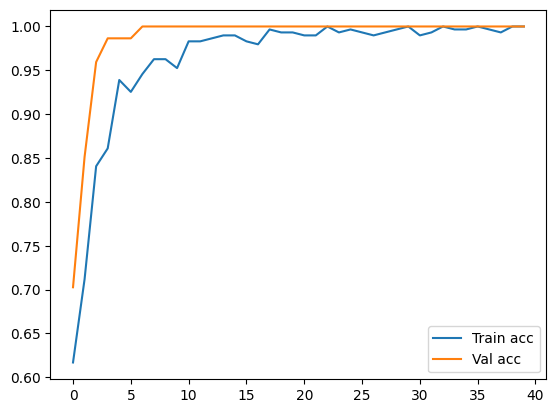

In [39]:
# Plotting accuracy curves
plt.plot(r.history['acc'], label='Train acc')
plt.plot(r.history['val_acc'], label='Val acc')
plt.legend()
plt.show()

In [42]:
# Printings
best_train_loss = min(r.history['loss'])
print(f"Best train loss : {best_train_loss}")

best_val_loss = min(r.history['val_loss'])
print(f"Best validation loss : {best_val_loss}")

Best train loss : 0.1682194024324417
Best validation loss : 0.12461091578006744


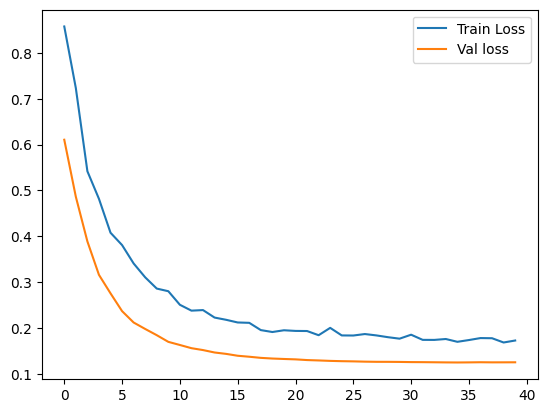

In [41]:
# Plotting Loss curves
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

In [47]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

# Sigmoid
y_true = test_set.classes                       # 0=fault, 1=no_fault
y_prob = model.predict(test_set, verbose=0).ravel()

# Class 'no_fault'
pos_idx = training_set.class_indices['no_fault']  # =1
y_true_pos = (y_true == pos_idx).astype(int)

# F1 threshold
prec, rec, thr = precision_recall_curve(y_true_pos, y_prob)
f1 = 2 * prec * rec / (prec + rec + 1e-9)
best_idx = f1[:-1].argmax()
best_thr = float(thr[best_idx])
print("Best threshold:", best_thr, " | Best F1:", float(f1[best_idx]))

y_pred = (y_prob >= best_thr).astype(int)

print(classification_report(
    y_true_pos, y_pred,
    target_names=['fault (neg)', 'no_fault (pos)']
))
print(confusion_matrix(y_true_pos, y_pred))

Best threshold: 0.9397190809249878  | Best F1: 0.9999999995
                precision    recall  f1-score   support

   fault (neg)       1.00      1.00      1.00        35
no_fault (pos)       1.00      1.00      1.00        39

      accuracy                           1.00        74
     macro avg       1.00      1.00      1.00        74
  weighted avg       1.00      1.00      1.00        74

[[35  0]
 [ 0 39]]


### Testing the trained model on new images (you can run it independently from this cell)

In [85]:
# Importing libraries for prediction
import os, numpy as np, cv2
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

In [95]:
# Loading the trained model
BEST_THR = 0.9397190809249878   # best_thr
best_model_file = f"{PROJECT_ROOT}/model/thermal-image-model.keras"

In [96]:
# Mapping, image size, load best model
CLASS_INDEX = {'fault': 0, 'no_fault': 1}
idx2name = {v: k for k, v in CLASS_INDEX.items()}

target_size = (IMAGE_SIZE[0], IMAGE_SIZE[1]) if 'IMAGE_SIZE' in globals() else (224, 224)

model = tf.keras.models.load_model(best_model_file)

In [97]:
def preprocess_for_model(img_path, target_size=target_size):
    """Load RGB, resize, to array, batch dim, preprocess_input (ResNet50)."""
    img = load_img(img_path, target_size=target_size, color_mode='rgb')
    x = img_to_array(img)            # (H,W,3)
    x = np.expand_dims(x, axis=0)    # (1,H,W,3)
    x = preprocess_input(x)          # like in datagen
    return x

In [98]:
def predict_one(img_path, model, best_thr=BEST_THR):
    x = preprocess_for_model(img_path)
    y = model.predict(x, verbose=0)

    # 1-neuron sigmoid head (binary): y ~ P(no_fault)
    if y.shape[-1] == 1:
        p_no_fault = float(y.ravel()[0])
        p_fault = 1.0 - p_no_fault
        pred_idx = int(p_no_fault >= best_thr)   # 0=fault, 1=no_fault
        pred_name = idx2name[pred_idx]
        return {
            'prob_fault': p_fault,
            'prob_no_fault': p_no_fault,
            'threshold': best_thr,
            'pred_idx': pred_idx,
            'pred_name': pred_name,
        }

    # 2-neuron softmax head (for oldest model)
    elif y.shape[-1] == 2:
        p_fault, p_no_fault = float(y[0][0]), float(y[0][1])
        pred_idx = int(np.argmax(y[0]))
        pred_name = idx2name[pred_idx]
        return {
            'prob_fault': p_fault,
            'prob_no_fault': p_no_fault,
            'threshold': 0.5,
            'pred_idx': pred_idx,
            'pred_name': pred_name,
        }

    else:
        raise ValueError(f"Unexpected model output shape: {y.shape}")

In [122]:
# Test image path
testImagePath = f"{testMyImagesFolder}/no_fault/no_fault_196.png"

In [123]:
# Prediction
res = predict_one(testImagePath, model, BEST_THR)
print(res)

{'prob_fault': 0.0241013765335083, 'prob_no_fault': 0.9758986234664917, 'threshold': 0.9397190809249878, 'pred_idx': 1, 'pred_name': 'no_fault'}


In [124]:
# Draw text to original image
img = cv2.imread(testImagePath)  # BGR
H, W = img.shape[:2]
label = res['pred_name']

font = cv2.FONT_HERSHEY_SIMPLEX
scale = max(0.5, min(5.0, 0.06 * H / 20))
thickness = max(2, int(round(scale * 0.8)))
(text_w, text_h), baseline = cv2.getTextSize(label, font, scale, thickness)
x = (W - text_w) // 2
y = H - baseline - max(5, int(round(0.01 * H)))
y = max(y, text_h)
_=cv2.putText(img, label, (x, y), font, scale, (0, 255, 255), thickness, cv2.LINE_AA)

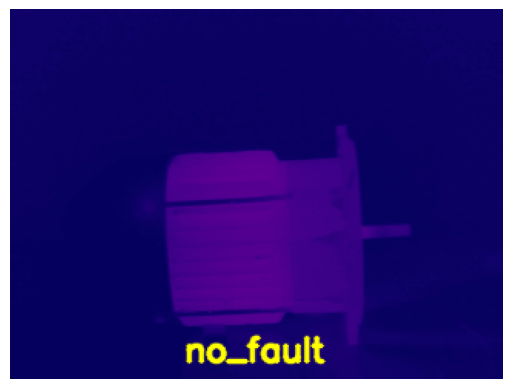

In [125]:
# Display
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb); plt.axis("off"); plt.show()

In [126]:
# Save
from pathlib import Path

src = Path(testImagePath)
stem = src.stem

out_dir = Path(f"{PROJECT_ROOT}/prediction") # Modified to create a Path object
out_path = out_dir / f"{stem}_predicted.png"
plt.imsave(str(out_path), rgb)

print(f"Saved: {out_path}")

Saved: /content/drive/MyDrive/Colab Notebooks/Electric_Motor_Fault_Diagnosis_based_on_Thermal_Images/data/prediction/no_fault_196_predicted.png


### Debug

In [104]:
import os, hashlib

def sha256(fp):
    with open(fp, "rb") as f:
        return hashlib.sha256(f.read()).hexdigest()

train_files = [os.path.join(trainMyImagesFolder, p) for p in training_set.filenames]
val_files   = [os.path.join(testMyImagesFolder, p)  for p in test_set.filenames]

# 1) Basename overlap
overlap_names = set(map(os.path.basename, train_files)) & set(map(os.path.basename, val_files))
print("Basename overlap:", len(overlap_names))

# 2) Duplicate check
train_hashes = {sha256(p) for p in train_files}
val_hashes   = {sha256(p) for p in val_files}
print("Exact duplicate images:", len(train_hashes & val_hashes))


Basename overlap: 0
Exact duplicate images: 0


In [106]:
from collections import Counter
print("TRAIN class_indices:", training_set.class_indices)
print("VAL   class_indices:", test_set.class_indices)

train_cnt = Counter(training_set.classes)
val_cnt   = Counter(test_set.classes)
ix2name = {v:k for k,v in training_set.class_indices.items()}
print("Train counts:", {ix2name[k]: v for k,v in train_cnt.items()})
print("Val counts:",   {ix2name[k]: v for k,v in val_cnt.items()})

# looks like the class mapping is OK.


TRAIN class_indices: {'fault': 0, 'no_fault': 1}
VAL   class_indices: {'fault': 0, 'no_fault': 1}
Train counts: {'fault': 138, 'no_fault': 157}
Val counts: {'fault': 35, 'no_fault': 39}
